## CAM(Class Activation Map) 
* 이미지 내에서 어느 부분이 모델의 의사결정에 큰 영향을 미쳤는지를 시각화하는 기술이다.
* Reference: "Learning Deep Features for Discriminative Localization" by B. Zhou et al., 2015"

In [7]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [9]:
# GPU vs CPU
# 현재 가능한 장치를 확인한다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
transform = transforms.Compose([transforms.Resize(128), transforms.ToTensor()])
trainset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform) # 96x96
trainloader = torch.utils.data.DataLoader(trainset, batch_size=40, shuffle=True)

# 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck

Files already downloaded and verified


In [11]:
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features # fc의 입력 노드 수를 산출한다. 512개
model.fc = nn.Linear(num_ftrs, 10) # fc를 nn.Linear(num_ftrs, 10)로 대체한다.
model = model.to(device)

##  모델 학습

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)

In [14]:
for epoch in range(20):

    running_loss = 0.0
    for data in trainloader:
        
        inputs, labels = data[0].to(device), data[1].to(device)
          
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    cost = running_loss / len(trainloader)        
    print('[%d] loss: %.3f' %(epoch + 1, cost))  

torch.save(model.state_dict(), './stl10_resnet18.pth')      

print('Finished Training')

[1] loss: 0.060
[2] loss: 0.064
[3] loss: 0.053
[4] loss: 0.056
[5] loss: 0.067
[6] loss: 0.052
[7] loss: 0.047
[8] loss: 0.048
[9] loss: 0.065
[10] loss: 0.074
[11] loss: 0.054
[12] loss: 0.054
[13] loss: 0.064
[14] loss: 0.043
[15] loss: 0.063
[16] loss: 0.053
[17] loss: 0.031
[18] loss: 0.037
[19] loss: 0.073
[20] loss: 0.071
Finished Training


In [15]:
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))

Accuracy of the network on the train images: 99 %


##  모델 구조

In [16]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## CAM 모델 구축

In [17]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [36]:
def cam(model, trainset, img_sample, img_size):
    model.eval()
    with torch.no_grad(): # requires_grad 비활성화

        model.layer4[1].bn2.register_forward_hook(get_activation('final')) # feature extraction의 마지막 feature map 구하기
        data, label = trainset[img_sample] # 이미지 한 장과 라벨 불러오기
        data.unsqueeze_(0) # 4차원 3차원 [피쳐수 ,너비, 높이] -> [1,피쳐수 ,너비, 높이]
        output = model(data.to(device))
        _, prediction = torch.max(output, 1)
        
        act = activation['final'].squeeze() # 4차원 [1,피쳐수 ,너비, 높이] -> 3차원 [피쳐수 ,너비, 높이]
        w = model.fc.weight # classifer의 가중치 불러오기
        
        for idx in range(act.size(0)): # CAM 연산
            if idx == 0:
                tmp = act[idx] * w[prediction.item()][idx] 
            else:
                tmp += act[idx] * w[prediction.item()][idx]

        # 모든 이미지 팍셀값을 0~255로 스케일하기 
        normalized_cam = tmp.cpu().numpy()
        normalized_cam = (normalized_cam - np.min(normalized_cam)) / (np.max(normalized_cam) - np.min(normalized_cam))
        original_img = np.uint8((data[0][0] / 2 + 0.5) * 255)

        # 원본 이미지 사이즈로 리사이즈
        cam_img = cv2.resize(np.uint8(normalized_cam * 255), dsize=(img_size, img_size)) 
        
    return cam_img, original_img, prediction, w, normalized_cam, act

In [41]:
def plot_cam(model, trainset, img_size, start):
    end = start + 20
    fig, axs = plt.subplots(2, (end - start + 1) // 2, figsize=(20, 5))
    fig.subplots_adjust(hspace=.01, wspace=.01)
    axs = axs.ravel()

    for i in range(start, end):
        cam_img, original_img, prediction, w, n_cam, act = cam(model, trainset, i, img_size)

        axs[i - start].imshow(original_img, cmap='gray')
        axs[i - start].imshow(cam_img, cmap='jet', alpha=.5)
        axs[i - start].axis('off')
        print(prediction)
        print(w.size())
        print(n_cam)
        print(act.size())

    plt.show()
    fig.savefig('cam.png')

tensor([0], device='cuda:0')
torch.Size([10, 512])
[[0.08411105 0.49959958 0.7555416  0.46236748]
 [0.23515446 0.7112307  1.         0.6992412 ]
 [0.18691483 0.6449961  0.96032846 0.66794103]
 [0.         0.3589678  0.6434189  0.44675705]]
torch.Size([512, 4, 4])
tensor([6], device='cuda:0')
torch.Size([10, 512])
[[0.         0.3653947  0.5605023  0.28468168]
 [0.28218144 0.810004   1.         0.54835755]
 [0.33946788 0.77436715 0.83331597 0.40670186]
 [0.14034979 0.37995943 0.37101036 0.11271982]]
torch.Size([512, 4, 4])
tensor([0], device='cuda:0')
torch.Size([10, 512])
[[0.44376874 0.981801   0.8979705  0.21507701]
 [0.46242586 1.         0.95581186 0.33976388]
 [0.30363598 0.75276583 0.6985304  0.20109135]
 [0.17533012 0.46984988 0.38461405 0.        ]]
torch.Size([512, 4, 4])
tensor([8], device='cuda:0')
torch.Size([10, 512])
[[0.         0.14002731 0.19811016 0.10213138]
 [0.3869802  0.70294344 0.7723119  0.47967863]
 [0.55024195 0.94904083 1.         0.6214812 ]
 [0.45722717 0.7

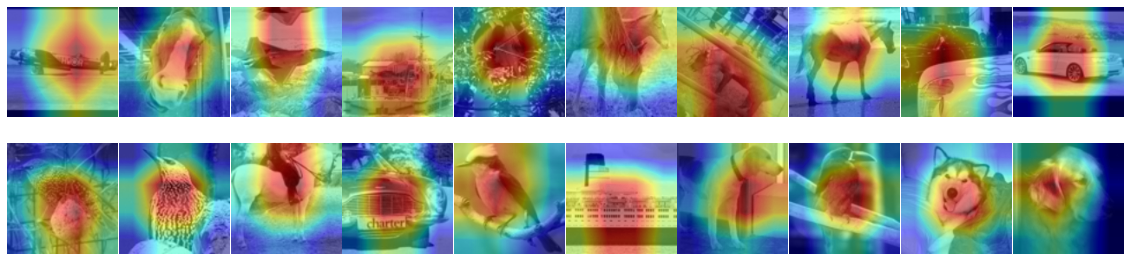

In [42]:
plot_cam(model, trainset, 128, 10)